# Pipeline TE

In [2]:
import os
os.chdir('/home/clemens/armed_conflict_avalanche/')

from workspace.utils import *
from voronoi_globe.interface import load_voronoi
from arcolanche.pipeline import *
from arcolanche.transfer_entropy_func import *

import statsmodels.api as sm

from utils_CB import get_coarsegrained, plot_cells, get_ids_from_centroid

from math import factorial

from shapely.geometry import LineString
from keplergl import KeplerGl


# Data, subset

In [3]:
conflict_type = "battles"
mesoscale = (32,453,3) #(dt, dx, gridix)
coarse = (32, 80, 3)

dt, dx, gridix = mesoscale

#data
load_pickle(f"avalanches/{conflict_type}/gridix_{gridix}/te/conflict_ev_{str(dt)}_{str(dx)}.p")
count_ts = get_coarsegrained(conflict_type, scale = mesoscale, binary=True)
polygons = load_voronoi(dx, gridix) #dx=57/b=528km, gridix=3

Subset of dataset is used: Construct.py subsets neighborhood of degree three around central node 7311. Quite messy way to do it but yeah.

Cells in subset: 35
tuples in subset of size 3: 1190.0
dt: 32, dx: 453 gridix: 3


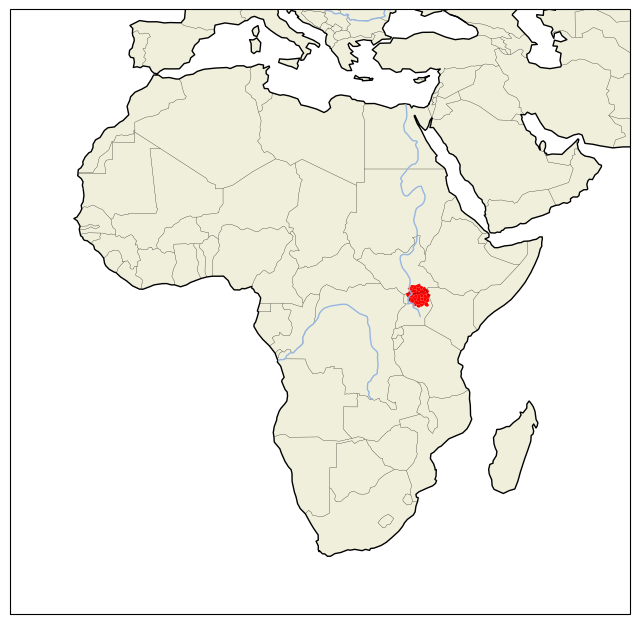

In [4]:
size = 3
degree = 2
centroid = 7311 #counts: 218 
cell_ids = get_ids_from_centroid(polygons, size= size, centroid = 7311)
print("Cells in subset:", len(cell_ids))


def binomial(n, k):
#number of unique k sets in n
    return (factorial(n)/(factorial(k)*factorial(n-k)))

print(f"tuples in subset of size {size}:", binomial(len(cell_ids), 2)*2)

#Plot subset (used in pipeline)
plot_cells(cell_ids, mesoscale, "battles", verbose=False)

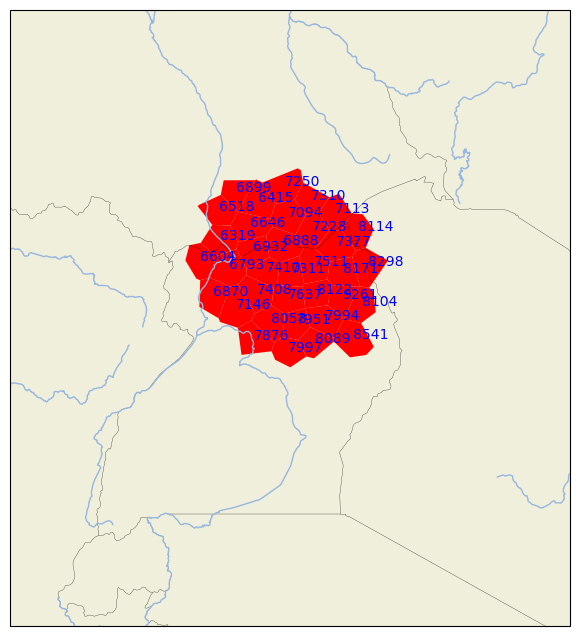

In [5]:
# Zoom in
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection=ccrs.PlateCarree())

# Specify polygon and event here
for i, x in enumerate(cell_ids):
    poly = polygons.loc[[x]]
    poly.plot(ax=ax, color="red")
    
    # Get the centroid of the polygon
    centroid = poly.geometry.centroid.iloc[0]
    # Place the index of the polygon as text on the map
    ax.text(centroid.x, centroid.y, str(x), color='blue', transform=ccrs.Geodetic())

ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linewidth=0.2)
ax.add_feature(cfeature.LAND)   
ax.add_feature(cfeature.RIVERS)

# Zoom in on Kenya, South Sudan, and Uganda

ax.set_extent([28, 38, -3, 8], crs=ccrs.PlateCarree())

plt.show()

# Avalanche construction/Get edges

In [6]:
#create avalanche (only create causla graph -> setup avalanche is commented out)
ava_1 = Avalanche(dt = dt, dx = dx, gridix=3, degree=1, setup=True)
ava_2 = Avalanche(dt = dt, dx = dx, gridix=3, degree=2, setup=True)

#get (tuple), TEs
#self_edges = ava_1.self_edges
#pair_edges = ava_1.pair_edges

print(ava_1.causal_graph) #esged: only significant MI/TE
print(ava_2.causal_graph)

/home/clemens/miniconda3/envs/conflict/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/home/clemens/miniconda3/envs/conflict/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


CausalGraph with 3085 nodes and 2817 edges
CausalGraph with 3085 nodes and 5891 edges


In [7]:
#ava_1.time_series.loc[]
#ava_1.avalanches

In [8]:
ava_1.avalanches
#ava_1.event_t

ava_box = [[tuple(i) for i in ava_1.time_series.loc[a].drop_duplicates()\
                    .values[:,::-1]] for a in ava_1.avalanches]


#ava_event = ava.avalanches
ava_1.avalanche_events(3)

{0: [37]}

In [9]:
ava_2.avalanches
#len(ava_2.avalanches) #9350

[[6, 9, 18, 20],
 [12, 15],
 [22],
 [37],
 [52118, 52133, 52148, 52157, 52156],
 [52119],
 [52121, 52117, 52135, 51999, 52006, 52060],
 [208435],
 [52130],
 [148],
 [153, 163],
 [157, 160],
 [159],
 [161],
 [166, 172],
 [168],
 [52137,
  52208,
  52241,
  51984,
  51977,
  51981,
  51987,
  52004,
  52001,
  52105,
  52108,
  52107,
  52134,
  52142,
  52161,
  52126,
  52124,
  52154,
  52093,
  52094,
  52112,
  52113,
  52102,
  52101,
  52103,
  52099,
  52125,
  51917,
  51884,
  51913,
  51928,
  51976,
  51980,
  51986,
  51809,
  51815,
  51862,
  51863,
  51864,
  51843,
  51993,
  52005,
  52069,
  52075,
  52084,
  52025,
  52027,
  52026,
  52031,
  52034,
  52058,
  52064,
  51845,
  51979,
  51990,
  52015,
  52030,
  52051,
  52052,
  51762,
  51840,
  51844,
  51853,
  51896,
  51904,
  51914,
  51961,
  52334,
  52316,
  52335,
  52195,
  52196,
  52212,
  52245,
  52246,
  52247,
  52323,
  52328,
  52331,
  52336,
  52337,
  52338,
  52343,
  52342,
  52345,
  52294,

In [10]:
ts = ava_1.time_series_CG_matrix

time_series = conflict_ev[["t","x"]]
print(time_series)

tx_groups = time_series.groupby(['t','x'])


tx_groups.groups.keys() #(t, x): [events]
#time_series




          t      x
236742    0   4868
236743    0   3404
32482     0   6325
158850    0   9335
265178    0   7408
...     ...    ...
234461  262   5135
57029   262   8109
57030   262   7569
196379  262  11904
196378  262  12526

[55527 rows x 2 columns]


dict_keys([(0, 1043), (0, 1308), (0, 1691), (0, 2385), (0, 2769), (0, 2860), (0, 3047), (0, 3243), (0, 3404), (0, 3703), (0, 4176), (0, 4256), (0, 4288), (0, 4357), (0, 4430), (0, 4548), (0, 4549), (0, 4583), (0, 4611), (0, 4783), (0, 4868), (0, 5640), (0, 5741), (0, 6147), (0, 6257), (0, 6325), (0, 6769), (0, 6906), (0, 7408), (0, 7689), (0, 7718), (0, 8109), (0, 8119), (0, 8418), (0, 8948), (0, 9335), (0, 10373), (0, 10466), (0, 12183), (0, 12288), (0, 12611), (0, 13156), (0, 13493), (0, 14264), (0, 14284), (1, 1308), (1, 3264), (1, 3435), (1, 3703), (1, 3823), (1, 4033), (1, 4633), (1, 6034), (1, 6325), (1, 6553), (1, 6775), (1, 6906), (1, 7310), (1, 7373), (1, 7408), (1, 7550), (1, 7636), (1, 8948), (1, 9112), (1, 9131), (1, 9469), (1, 9759), (1, 9932), (1, 10329), (1, 11291), (1, 12611), (1, 13038), (1, 13229), (1, 13282), (1, 13398), (1, 14078), (1, 14125), (1, 14264), (1, 14287), (1, 14704), (1, 15404), (1, 23070), (2, 2728), (2, 2972), (2, 3047), (2, 3703), (2, 3715), (2, 4033)

In [ ]:
d = 16
dt = 64
dx = 320

df = pd.read_csv(f"/home/clemens/armed_conflict_avalanche/Results/summary/d{d}_dt{dt}_dx{dx}.csv")
df.drop(columns = ["Unnamed: 0"], inplace = True)
df

# Functions

In [11]:
def calculate_significant_edges(self_edges, pair_edges, summary = False):
        
    significant_edges = [[] for _ in range(degree+1)]
    counts = np.zeros(degree+1)
    
    #self edges
    for poly, (te, te_shuffle) in self_edges.items():
        if (te > te_shuffle).mean() >= (95 / 100):
            significant_edges[0].append([(poly, poly), te])
    counts[0] = len(self_edges)

    #pair edges
    for pair, (te, te_shuffle) in pair_edges.items():
        d = pair[2]
        if 1 <= d <= degree:
            counts[d] += 1
            if (te > te_shuffle).mean() >= (95/100): #threshold!
                significant_edges[d].append([(pair[0], pair[1]), te])            
    
    #ratio dataframe 
    if summary:
        df = pd.DataFrame(
            {
                "Degree": np.arange(degree+1),
                "Total edges": counts,
                "Significant edges": [len(edges) for edges in significant_edges],
            }
        )
        df["Ratio"] = round(df["Significant edges"] / df["Total edges"], 3)
        
        return df, significant_edges
    
    else:
        return significant_edges

In [12]:
def plot_save_ecdf(significant_edges):
    #get TEs
    for d in range(1, degree+1):
        sig = significant_edges[d]
        tes = [te for tuples, te in sig]
        
        # Compute ECDFs using statsmodels
        ecdf = sm.distributions.ECDF(tes)
        x = np.sort(tes)
        y = ecdf(x)
        plt.plot(x, y, 'o', label=f"{d}st", color="C"+str(d), markersize=3)
    
    
    # Add labels and title
    plt.ylabel("CDF")
    plt.xlabel("TE")
    plt.title(f"TE CDF d{degree} dt{dt} dx{dx}")

    # Add legend
    plt.legend()

plot_save_ecdf(significant_edges)

NameError: name 'significant_edges' is not defined

In [ ]:
def save_map(t, s, polygons, significant_edges): 
    map_ = KeplerGl()
    
    for d in range(1, degree+1):
        sig = significant_edges[d]
        edges = [(pair[0], pair[1]) for pair, te in sig]
        edges_df = pd.DataFrame(edges, columns=["source", "target"])
        lines = []

        for index, row in edges_df.iterrows():
            source_polygon = polygons[polygons.index == row['source']].geometry.values[0]
            target_polygon = polygons[polygons.index == row['target']].geometry.values[0]

            # Create a line between centroids of source and target polygons
            line = LineString([source_polygon.centroid, target_polygon.centroid])
            lines.append({
                'type': 'Feature',
                'geometry': line.__geo_interface__,
                'properties': {
                    'source_id': int(row['source']),  # Ensure integer conversion
                    'target_id': int(row['target'])   # Ensure integer conversion
                }
            })

        lines_geojson = {'type': 'FeatureCollection', 'features': lines}
        lines_geojson = json.dumps(lines_geojson)
        map_.add_data(data=json.loads(lines_geojson), name=f'{d}st degree')
    
    polygons_geojson = polygons.to_json()
    map_.add_data(data=json.loads(polygons_geojson), name=f'Polygons, dx={s}')
    
    # Save the map as HTML or display it
    map_.save_to_html(file_name=f'Results/kepler/kepler_d{degree}_dt{t}_dx{s}.html')

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
Map saved to Results/kepler/kepler_d2_dt2_dx453.html!
